In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

In [4]:
image_dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 5510
Images in Train set: 22048


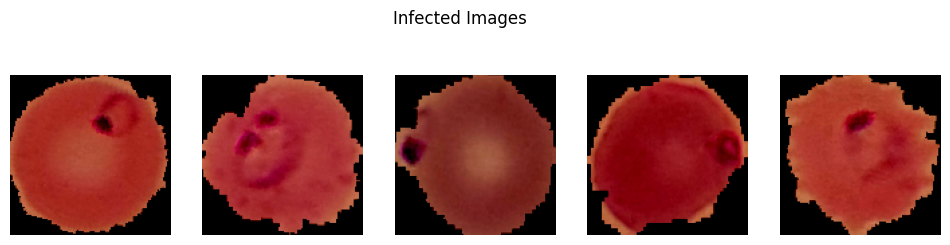

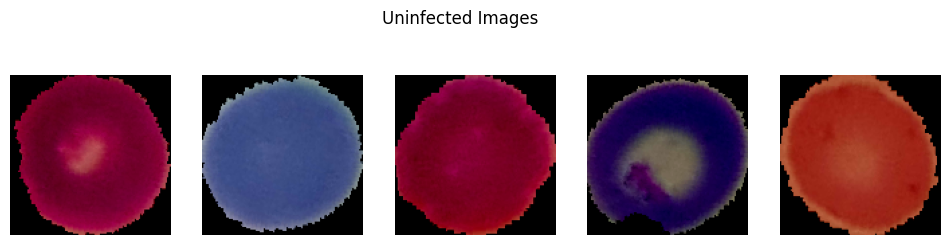

In [7]:

# Define a function to display images
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Define classes
classes = ['infected', 'uninfected']

# Function to get a batch of images from the loader
def get_batch(loader, class_index, num_images):
    for batch, labels in loader:
        images = batch[labels == class_index][:num_images]
        return images

# Get five images of infected class
infected_images = get_batch(train_loader, class_index=0, num_images=5)
show_images(infected_images, 'Infected Images')

# Get five images of uninfected class
uninfected_images = get_batch(train_loader, class_index=1, num_images=5)
show_images(uninfected_images, 'Uninfected Images')


In [8]:
class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out

In [9]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
num_epochs = 30
batch_size = 100 

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.
    correct = 0
    total = 0
    model.train()    # explicitly stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    # back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
     
    accuracy = correct / total
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(accuracy)
    
    print("Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%".format(epoch + 1, train_losses[-1], accuracy * 100))

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1, Loss: 0.4262, Accuracy: 74.28%
Epoch: 2, Loss: 0.1525, Accuracy: 92.87%
Epoch: 3, Loss: 0.1253, Accuracy: 94.61%
Epoch: 4, Loss: 0.1168, Accuracy: 94.93%
Epoch: 5, Loss: 0.1093, Accuracy: 95.41%
Epoch: 6, Loss: 0.1037, Accuracy: 95.62%
Epoch: 7, Loss: 0.1021, Accuracy: 95.64%
Epoch: 8, Loss: 0.0953, Accuracy: 95.87%
Epoch: 9, Loss: 0.0976, Accuracy: 95.88%
Epoch: 10, Loss: 0.0949, Accuracy: 95.95%
Epoch: 11, Loss: 0.0923, Accuracy: 96.03%
Epoch: 12, Loss: 0.0927, Accuracy: 95.91%
Epoch: 13, Loss: 0.0894, Accuracy: 96.09%
Epoch: 14, Loss: 0.0911, Accuracy: 96.05%
Epoch: 15, Loss: 0.0887, Accuracy: 96.21%
Epoch: 16, Loss: 0.0886, Accuracy: 96.24%
Epoch: 17, Loss: 0.0863, Accuracy: 96.29%
Epoch: 18, Loss: 0.0876, Accuracy: 96.20%
Epoch: 19, Loss: 0.0842, Accuracy: 96.27%
Epoch: 20, Loss: 0.0842, Accuracy: 96.33%
Epoch: 21, Loss: 0.0834, Accuracy: 96.37%
Epoch: 22, Loss: 0.0814, Accuracy: 96.37%
Epoch: 23, Loss: 0.0824, Accuracy: 96.38%
Epoch: 24, Loss: 0.0803, Accuracy: 96.54%
E

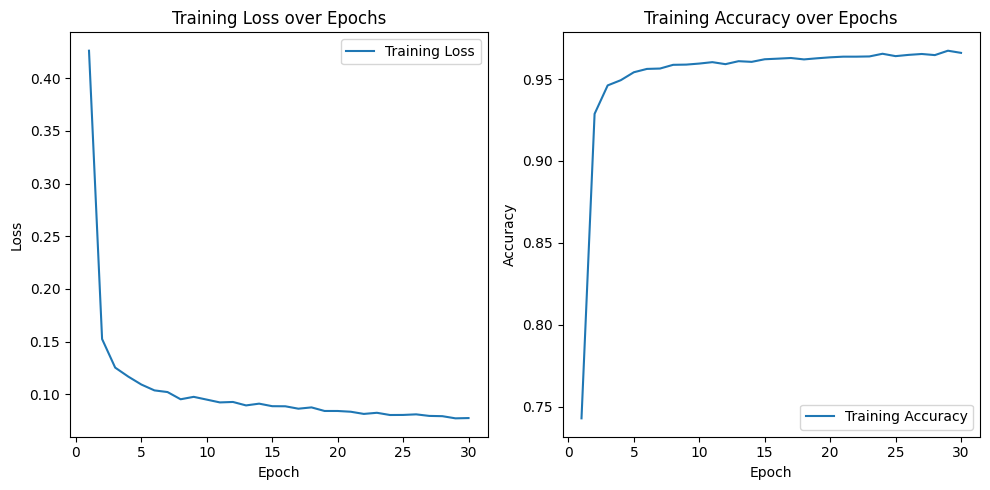

In [11]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
torch.save(model.state_dict(), "model.pt")

In [13]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.55%

Accuracy of infected :  96.80%   [2660 / 2748]
Accuracy of uninfected :  96.31%   [2660 / 2762]


In [14]:
#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))

Accuracy Score: 
0.9655

Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2748
           1       0.97      0.96      0.97      2762

    accuracy                           0.97      5510
   macro avg       0.97      0.97      0.97      5510
weighted avg       0.97      0.97      0.97      5510


Confusion Matrix: 
            Predicted No  Predicted Yes
Actual No           2660             88
Actual Yes           102           2660


<Axes: >

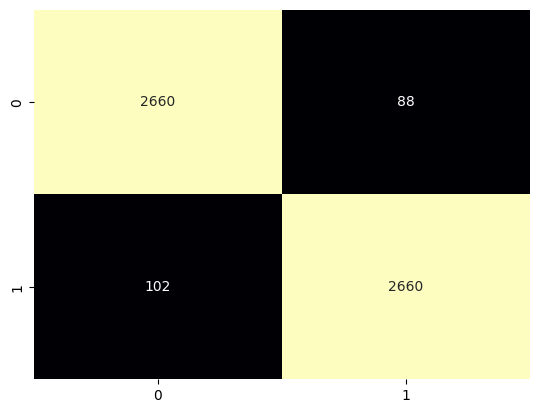

In [15]:

sns.heatmap(results, cmap="magma", annot=True, fmt="d", cbar=False)